In [ ]:
!pip install python-bidi
!pip install arabic-reshaper

In [ ]:
import os
import sys
import json
import pickle
import time
from os import listdir
from os.path import isfile, join
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import tensorflow as tf
print(f'TF version: {tf.__version__}')
import keras
print(f'Keras version: {keras.__version__}')
from keras import backend as K

from keras.models import Sequential
from keras.layers import concatenate, Input,Dense, Dropout, Flatten, Reshape, GlobalAveragePooling1D, BatchNormalization,LSTM,Bidirectional,Conv2D, MaxPooling2D, Conv1D, MaxPooling1D
from tensorflow.keras.utils import plot_model
from keras.utils import np_utils
from keras.callbacks import Callback
from keras.regularizers import l1, l2, l1_l2
import tensorflow.keras.backend as kb
from bidi.algorithm import get_display
import arabic_reshaper

from google.colab import drive
drive.mount('/content/drive')


TF version: 2.5.0
Keras version: 2.5.0
Mounted at /content/drive


# **Load Dataset**

In [ ]:
#!unzip /content/drive/MyDrive/Emaid_FDS/dataset.zip
!unzip /content/drive/MyDrive/Emaid_FDS/dataset_kalman.zip


xvalue = np.load('/content/x.npy')
yvalue = pd.read_csv('/content/y.csv')

X_train, X_test, y_train, y_test = train_test_split(xvalue, yvalue, test_size = 0.20, shuffle=True , random_state = 0)
X_train, X_val, y_train, y_val = train_test_split(X_train,  y_train, test_size = 0.20,shuffle=True, random_state = 0)

print(f'Shape of train feature is : {X_train.shape}')
print(f'Shape of validation feature is : {X_val.shape}')
print(f'Shape of test feature is : {X_test.shape}')

Archive:  /content/drive/MyDrive/Emaid_FDS/dataset_kalman.zip
  inflating: x.npy                   
  inflating: y.csv                   
Shape of train feature is : (76498, 250, 9)
Shape of validation feature is : (19125, 250, 9)
Shape of test feature is : (23906, 250, 9)


In [ ]:
y_train.head()

,Tag,FallType
61328,0,F09
106367,0,D03
19559,0,D17
71576,0,D03
66822,0,F10


# **Show dataset histogram**

In [ ]:
def fa(text):
    return get_display(arabic_reshaper.reshape(u'%s'% str(text)))

LABELS_status = [fa("عادی"),fa("هشدار"),fa("سقوط")]
pd.options.display.float_format = '{:.1f}'.format
sns.set()
plt.style.use('fast')
# 'Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10'

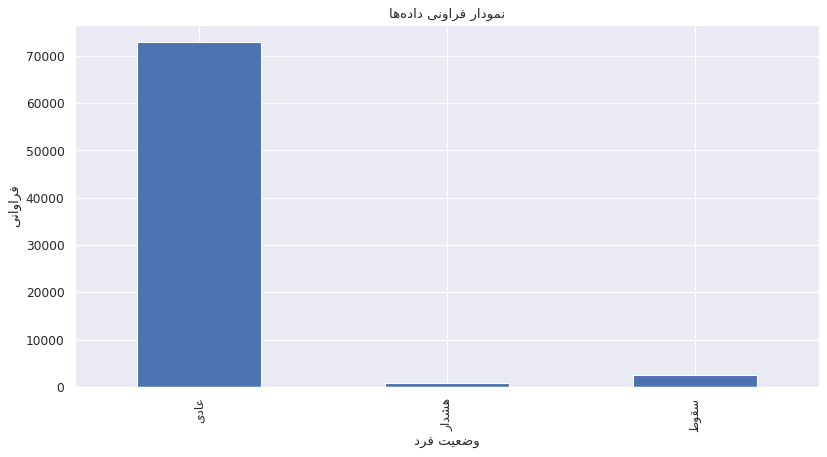

In [ ]:
plt.figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
ax = y_train['Tag'].value_counts(sort=False).plot(kind='bar',title=fa("نمودار فراونی داده‌ها"))
ax.set_xticks(range(0,3))
plt.xlabel(fa("وضعیت فرد"))
plt.ylabel(fa("فراوانی"))
ax.set_xticklabels([fa("عادی"),fa("هشدار"),fa("سقوط")])
plt.show()

# Convert every D type to BKG

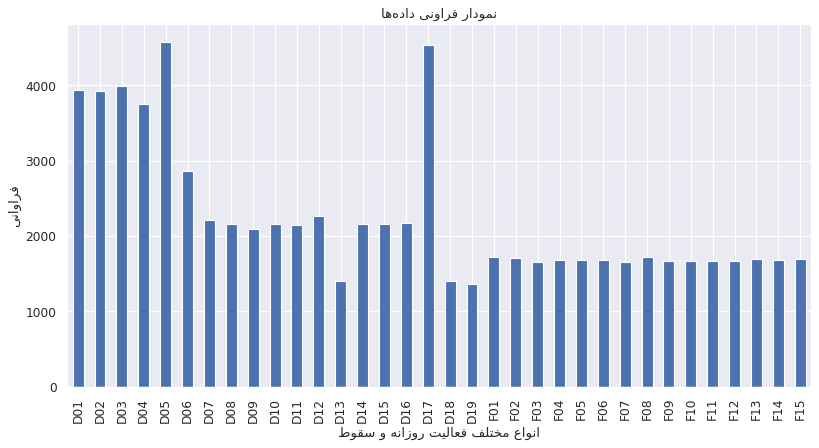

In [ ]:
plt.figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
data = pd.core.series.Series([f for f in y_train['FallType'] ]).value_counts(sort=False)
LABELS_type = sorted(data.index)
ax = data[sorted(data.index)].plot(kind='bar',title=fa("نمودار فراونی داده‌ها"))
ax.set_xticks(range(0,len(data.index)))
plt.xlabel(fa("انواع مختلف فعالیت روزانه و سقوط"))
plt.ylabel(fa("فراوانی"))
ax.set_xticklabels(sorted(data.index))
plt.show()

In [ ]:
y_train['FallType'] = y_train['FallType'].apply(lambda x : 'BKG' if x[0] == 'D' else x)
y_val['FallType'] = y_val['FallType'].apply(lambda x : 'BKG' if x[0] == 'D' else x)
y_test['FallType'] = y_test['FallType'].apply(lambda x : 'BKG' if x[0] == 'D' else x)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


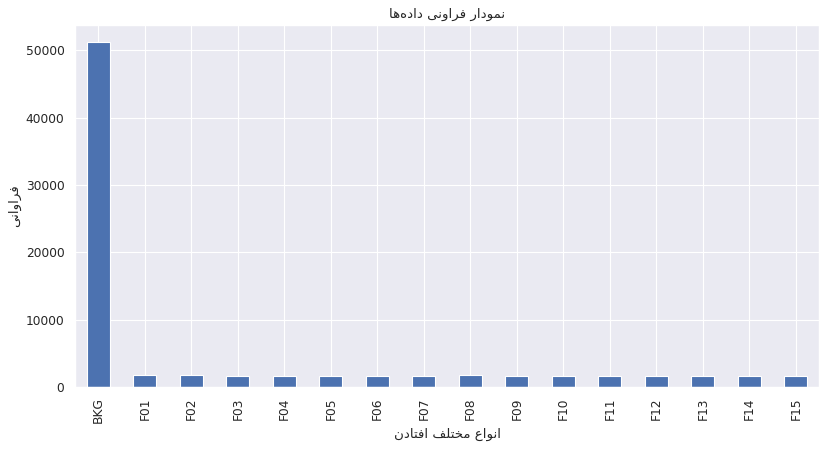

In [ ]:
plt.figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
data = pd.core.series.Series([f for f in y_train['FallType'] ]).value_counts(sort=False)
LABELS_type = sorted(data.index)
ax = data[sorted(data.index)].plot(kind='bar',title=fa("نمودار فراونی داده‌ها"))
ax.set_xticks(range(0,len(data.index)))
plt.xlabel(fa("انواع مختلف افتادن"))
plt.ylabel(fa("فراوانی"))
ax.set_xticklabels(sorted(data.index))
plt.show()

In [ ]:
def convert_to_float(x):
    try:
        return np.float(x)
    except:
        return np.nan

In [ ]:
def data_correction(row):    
    if(row['Tag']==0):
        return "BKG"
    return row['FallType']
y_train['FallType'] = y_train.apply(lambda row: data_correction(row),axis=1)
y_val['FallType'] = y_val.apply(lambda row: data_correction(row),axis=1)
y_test['FallType'] = y_test.apply(lambda row: data_correction(row),axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [ ]:
y_train['FallType'] = y_train['FallType'].apply(lambda x : int('0') if x == 'BKG' else int(x[1:]))
y_val['FallType'] = y_val['FallType'].apply(lambda x : int('0') if x == 'BKG' else int(x[1:]))
y_test['FallType'] = y_test['FallType'].apply(lambda x : int('0') if x == 'BKG' else int(x[1:]))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
# train
y_train_status = y_train['Tag']
y_train_type = y_train['FallType']
# validation
y_val_status = y_val['Tag']
y_val_type = y_val['FallType']
# test
y_test_status = y_test['Tag']
y_test_type = y_test['FallType']

In [ ]:
X_train = X_train.astype("float32")
y_train_status =y_train_status.astype("float32")
y_train_type =y_train_type.astype("float32")

X_val = X_val.astype("float32")
y_val_status =y_val_status.astype("float32")
y_val_type =y_val_type.astype("float32")

X_test = X_test.astype("float32")
y_test_status =y_test_status.astype("float32")
y_test_type =y_test_type.astype("float32")

## Convert lable to one-hot

In [ ]:
y_train_status = np_utils.to_categorical(y_train_status, 3)
y_val_status =np_utils.to_categorical(y_val_status, 3)
y_test_status = np_utils.to_categorical(y_test_status,3)

y_train_type = np_utils.to_categorical(y_train_type, 16)
y_val_type = np_utils.to_categorical(y_val_type, 16)
y_test_type = np_utils.to_categorical(y_test_type, 16)

In [ ]:
class_weight_status = [ 1.,
                sum(y_train_status[:,0]) /  sum(y_train_status[:,1]) ,
                sum(y_train_status[:,0]) /  sum(y_train_status[:,2])]
class_weight_status

[1.0, 78.70226537216828, 27.91009946442234]

In [ ]:
class_weight_type = []
for i in range(0,16):
    class_weight_type.append(sum(y_train_type[:,0]) / sum(y_train_type[:,i]))
class_weight_type

[1.0,
 383.6510416666667,
 404.7307692307692,
 435.8639053254438,
 416.1638418079096,
 413.8258426966292,
 393.90909090909093,
 355.8502415458937,
 349.1042654028436,
 377.74871794871797,
 385.65968586387436,
 375.82142857142856,
 383.6510416666667,
 373.9137055837563,
 409.22777777777776,
 402.5191256830601]

# Define weighted categorical crossentropy for both status and type

In [ ]:
def weighted_categorical_crossentropy_status(y_true, y_pred):
    y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
    y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
    loss = y_true * K.log(y_pred) * class_weight_status
    return  - K.mean(K.sum(loss, -1))

def weighted_categorical_crossentropy_type(y_true, y_pred):
    y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
    y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
    loss = y_true * K.log(y_pred) * class_weight_type
    return  - K.mean(K.sum(loss, -1))

# **CNN**


In [ ]:
Input_1= Input(shape=(250,9),name="Signal")
x = Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(250, 9))(Input_1)
x = BatchNormalization()(x)
x = MaxPooling1D(3)(x)

x = Conv1D(filters=32, kernel_size=3, activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling1D(3)(x)

x = Conv1D(filters=32, kernel_size=3, activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling1D(3)(x)

x =  GlobalAveragePooling1D()(x)

x = Dropout(0.5)(x)
out_status = Dense(32, activation='relu')(x)
out_status = Dense(16, activation='relu')(out_status)
out_status = Dense(3, activation='softmax',name="status")(out_status)

out_type = Dense(128, activation='relu')(x)
out_type = Dense(64, activation='relu')(out_type)
out_type = Dense(16, activation='softmax',name="type")(out_type)

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=2000,
    decay_rate=0.9)
optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)


model = keras.Model(inputs=Input_1, outputs=[out_status,out_type])
model.compile(optimizer = optimizer, 
              loss = [weighted_categorical_crossentropy_status,weighted_categorical_crossentropy_type],
              metrics = ['acc'],
              loss_weights=[1.0, 1.0])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Signal (InputLayer)             [(None, 250, 9)]     0                                            
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, 248, 32)      896         Signal[0][0]                     
__________________________________________________________________________________________________
batch_normalization_3 (BatchNor (None, 248, 32)      128         conv1d_3[0][0]                   
__________________________________________________________________________________________________
max_pooling1d_3 (MaxPooling1D)  (None, 82, 32)       0           batch_normalization_3[0][0]      
____________________________________________________________________________________________

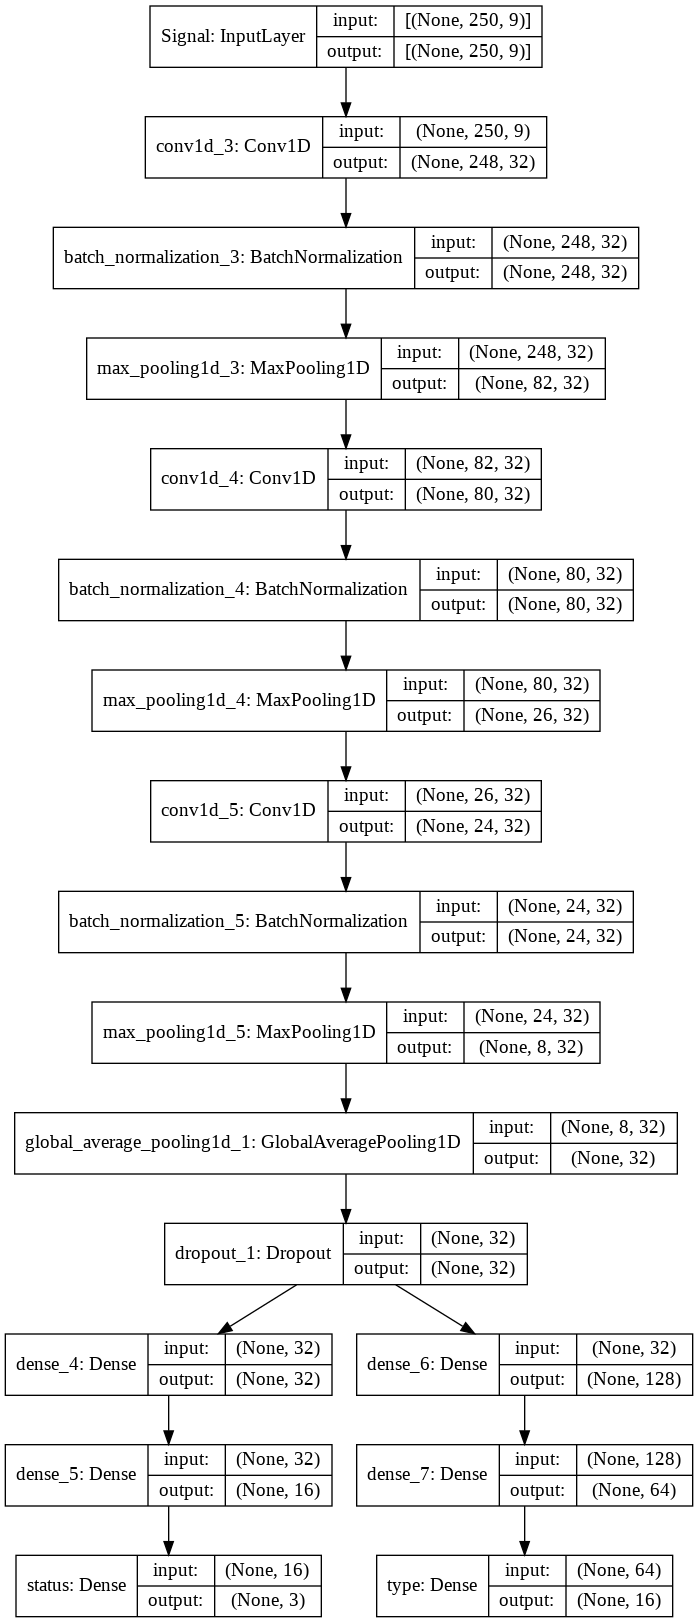

In [ ]:
plot_model(model, "multi_input_and_output_model.png", show_shapes=True)

## Fit model

In [ ]:
start_time = time.time()
callbacks_list = [keras.callbacks.ModelCheckpoint(filepath='/content/drive/MyDrive/Emaid_FDS/CNN_Model.h5',monitor='val_loss',save_best_only=True)]                                                   

history = model.fit(X_train,                                              
                    {"status": y_train_status, "type": y_train_type},
                      batch_size=64,
                      epochs=200,
                      callbacks=callbacks_list,                      
                      validation_data = (X_val, {"status": y_val_status, "type": y_val_type}),                      
                      verbose=1) 

json.dump(history.history, open(f"/content/drive/MyDrive/Emaid_FDS/CNN_History.json", "w"))
print("--- %s seconds ---" % (time.time() - start_time))

Epoch 1/200
1196/1196 [==============================] - 66s 15ms/step - loss: 44.4410 - status_loss: 2.6374 - type_loss: 41.8036 - status_acc: 0.6174 - type_acc: 0.3154 - val_loss: 36.7176 - val_status_loss: 1.5466 - val_type_loss: 35.1711 - val_status_acc: 0.8242 - val_type_acc: 0.5807
Epoch 2/200
1196/1196 [==============================] - 15s 12ms/step - loss: 37.6001 - status_loss: 1.8057 - type_loss: 35.7944 - status_acc: 0.8259 - type_acc: 0.7003 - val_loss: 33.6685 - val_status_loss: 1.3138 - val_type_loss: 32.3547 - val_status_acc: 0.8975 - val_type_acc: 0.8375
Epoch 3/200
1196/1196 [==============================] - 15s 12ms/step - loss: 36.1092 - status_loss: 1.6722 - type_loss: 34.4371 - status_acc: 0.8374 - type_acc: 0.7840 - val_loss: 32.8917 - val_status_loss: 1.1928 - val_type_loss: 31.6989 - val_status_acc: 0.9124 - val_type_acc: 0.8893
Epoch 4/200
1196/1196 [==============================] - 16s 13ms/step - loss: 36.1474 - status_loss: 1.6860 - type_loss: 34.4614 - s

#Load Model

In [ ]:
model = keras.models.load_model("/content/drive/MyDrive/Emaid_FDS/CNN_Model.h5",
                                custom_objects={'weighted_categorical_crossentropy_status': weighted_categorical_crossentropy_status,
                                                'weighted_categorical_crossentropy_type': weighted_categorical_crossentropy_type})

history = json.load(open(f"/content/drive/MyDrive/Emaid_FDS/CNN_History.json", "r"))

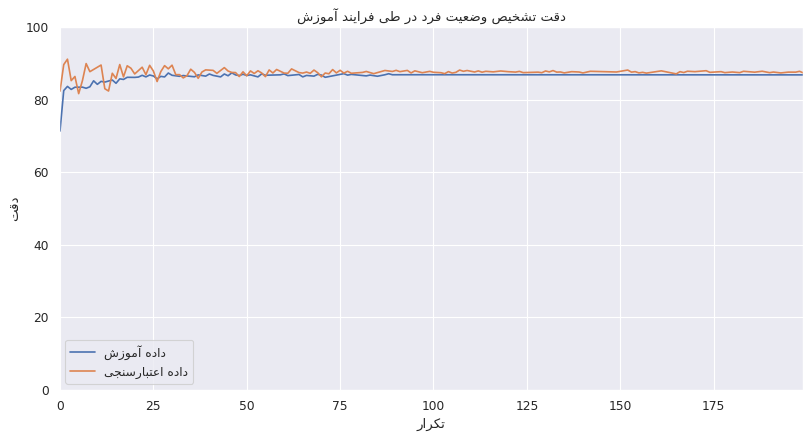

In [ ]:
plt.figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(np.array(history['status_acc']) * 100) 
plt.plot(np.array(history['val_status_acc']) * 100) 
plt.axis([-0.2, len(history['status_acc'])-1, 0, 100])
plt.title(fa("دقت تشخیص وضعیت فرد در طی فرایند آموزش"))
plt.xlabel(fa("تکرار"))
plt.ylabel(fa("دقت"))
plt.legend([fa('داده آموزش'),fa('داده اعتبارسنجی')])
plt.show()

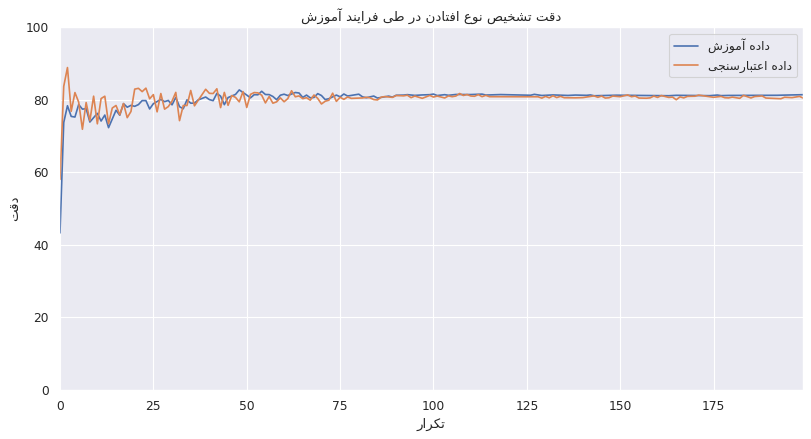

In [ ]:
plt.figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(np.array(history['type_acc']) * 100) 
plt.plot(np.array(history['val_type_acc']) * 100) 
plt.axis([-0.2, len(history['type_acc'])-1, 0, 100])
plt.title(fa("دقت تشخیص نوع افتادن در طی فرایند آموزش"))
plt.xlabel(fa("تکرار"))
plt.ylabel(fa("دقت"))
plt.legend([fa('داده آموزش'),fa('داده اعتبارسنجی')])
plt.show()

# **Confusion metrics**


In [ ]:
def show_confusion_matrix(matrix,fmt,LABELS):
    plt.figure(figsize=(10, 10))
    sns.heatmap(matrix,cmap="Reds",linecolor='white',linewidths=1,
                xticklabels=LABELS,yticklabels=LABELS,annot=True,fmt=fmt)    
    plt.title(fa("ماتریس درهم‌ریختگی"))
    plt.ylabel(fa("مقدار واقعی"))
    plt.xlabel(fa("مقدار پیش‌بینی شده"))
    plt.show()

def confusion_matrix(validations, predictions,LABELS):        
    matrix = metrics.confusion_matrix(validations, predictions)            
    show_confusion_matrix(matrix,"d",LABELS) # show for frequency        
    sensitivity =  np.divide(matrix.transpose(),np.sum(matrix, axis=1)).transpose() * 100
    show_confusion_matrix(sensitivity,".2f",LABELS)         
    return matrix

# Confusion matrix for train data

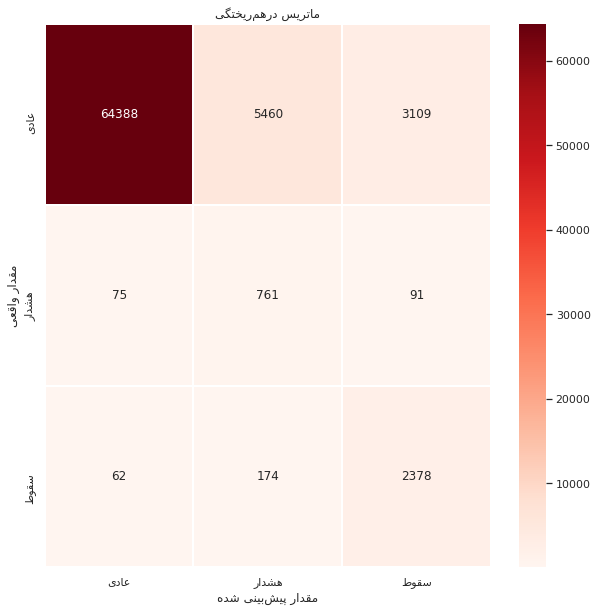

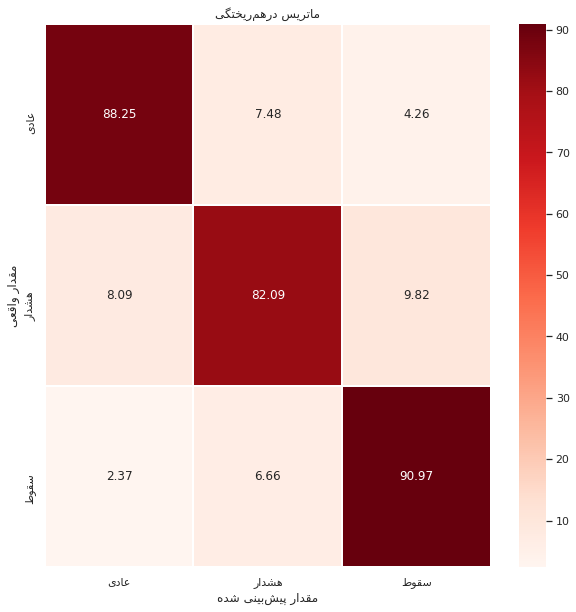

              precision    recall  f1-score   support

           0     0.9979    0.8825    0.9367     72957
           1     0.1190    0.8209    0.2079       927
           2     0.4263    0.9097    0.5806      2614

    accuracy                         0.8827     76498
   macro avg     0.5144    0.8711    0.5750     76498
weighted avg     0.9677    0.8827    0.9157     76498



In [ ]:
y_true = np.argmax(y_train_status, axis=1)
y_pred =  np.argmax(model.predict(X_train)[0], axis=1)
matrix = confusion_matrix(y_true,y_pred,LABELS_status)
print(classification_report(y_true, y_pred,digits=4))

# Confusion matrix for validation data


--- Confusion matrix for validation data ---



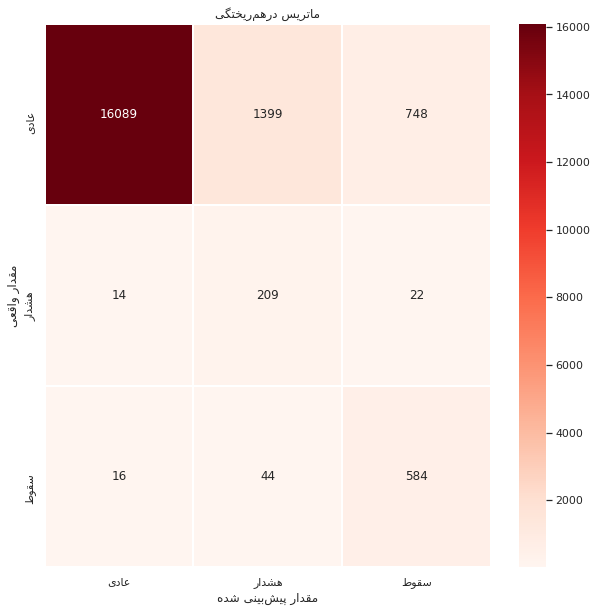

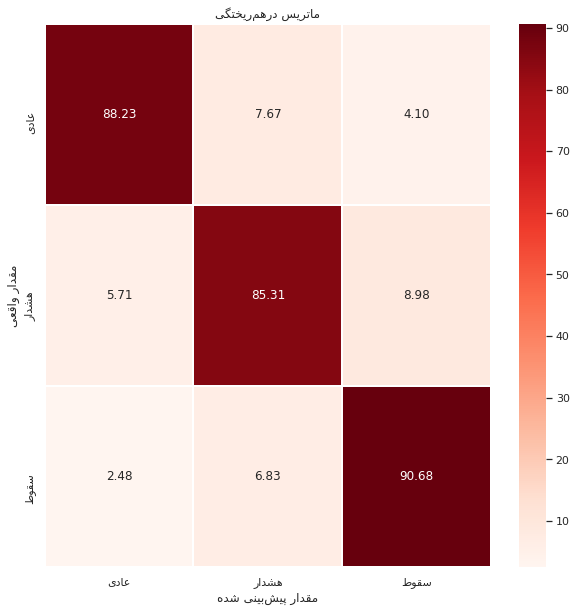

              precision    recall  f1-score   support

           0     0.9981    0.8823    0.9366     18236
           1     0.1265    0.8531    0.2203       245
           2     0.4313    0.9068    0.5846       644

    accuracy                         0.8827     19125
   macro avg     0.5187    0.8807    0.5805     19125
weighted avg     0.9679    0.8827    0.9156     19125



In [ ]:
print("\n--- Confusion matrix for validation data ---\n")
y_true = np.argmax(y_val_status, axis=1)
y_pred = np.argmax(model.predict(X_val)[0], axis=1)
matrix = confusion_matrix(y_true, y_pred,LABELS_status)
print(classification_report(y_true, y_pred,digits=4))

# Confusion matrix for test data


--- Confusion matrix for test data ---



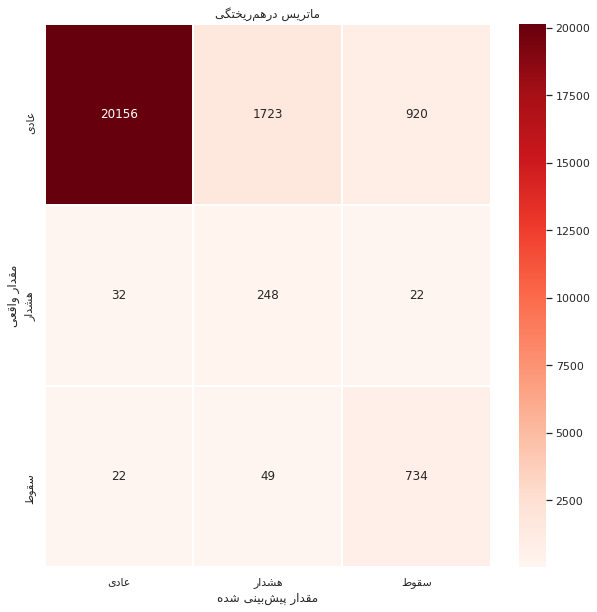

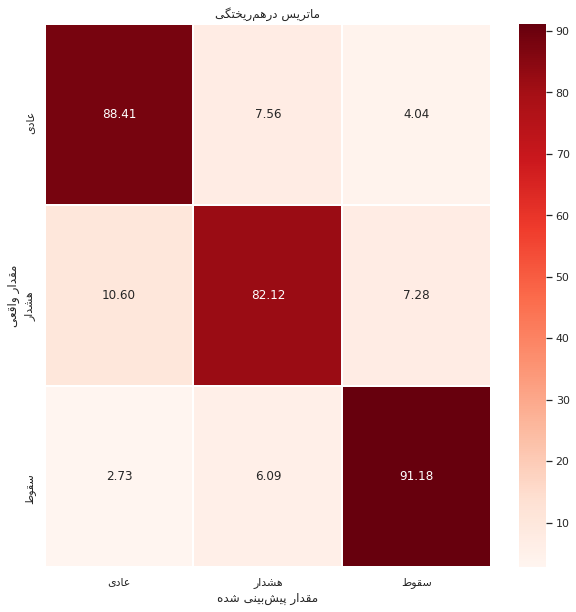

              precision    recall  f1-score   support

           0     0.9973    0.8841    0.9373     22799
           1     0.1228    0.8212    0.2136       302
           2     0.4379    0.9118    0.5917       805

    accuracy                         0.8842     23906
   macro avg     0.5193    0.8724    0.5809     23906
weighted avg     0.9674    0.8842    0.9165     23906



In [ ]:
print("\n--- Confusion matrix for test data ---\n")
y_true = np.argmax(y_test_status, axis=1)
y_pred = np.argmax(model.predict(X_test)[0], axis=1)
matrix = confusion_matrix(y_true, y_pred,LABELS_status)
print(classification_report(y_true, y_pred,digits=4))


--- Confusion matrix for all data ---



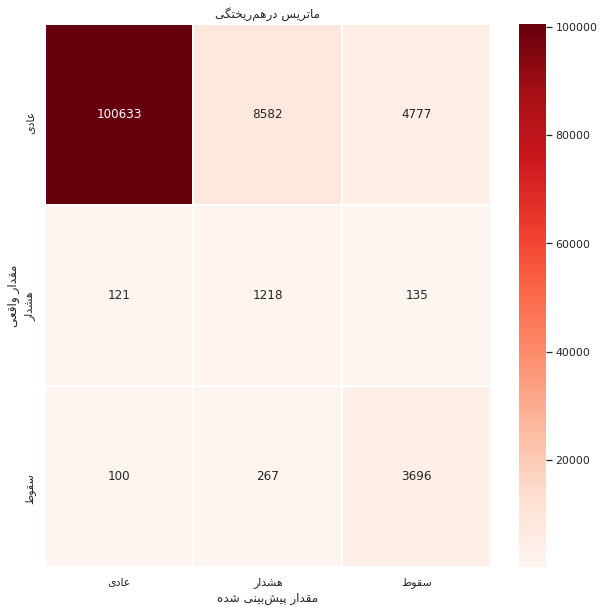

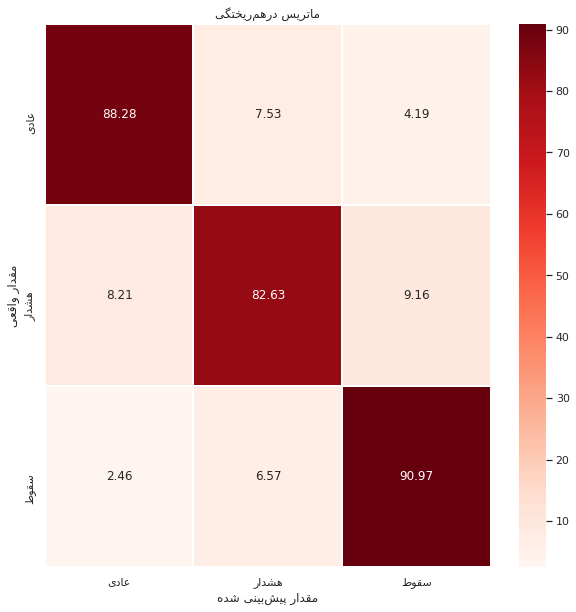

              precision    recall  f1-score   support

           0     0.9978    0.8828    0.9368    113992
           1     0.1210    0.8263    0.2111      1474
           2     0.4294    0.9097    0.5834      4063

    accuracy                         0.8830    119529
   macro avg     0.5161    0.8729    0.5771    119529
weighted avg     0.9677    0.8830    0.9158    119529



In [ ]:
print("\n--- Confusion matrix for all data ---\n")
y_true = np.argmax(np.concatenate([y_train_status,y_val_status,y_test_status]), axis=1)
y_pred = np.argmax(model.predict(np.concatenate([X_train,X_val,X_test]))[0], axis=1)
matrix = confusion_matrix(y_true, y_pred,LABELS_status)
print(classification_report(y_true, y_pred,digits=4))

In [ ]:
LABELS_type = [fa("ADL"),*LABELS_type]

In [ ]:
def show_confusion_matrix(matrix,fmt,LABELS):
    plt.figure(figsize=(15, 15))
    sns.heatmap(matrix,cmap="Reds",linecolor='white',linewidths=1,
                xticklabels=LABELS,yticklabels=LABELS,annot=True,fmt=fmt)    
    plt.title(fa("ماتریس درهم‌ریختگی"))
    plt.ylabel(fa("مقدار واقعی"))
    plt.xlabel(fa("مقدار پیش‌بینی شده"))
    plt.show()

def confusion_matrix(validations, predictions,LABELS):        
    matrix = metrics.confusion_matrix(validations, predictions)            
    show_confusion_matrix(matrix,"d",LABELS) # show for frequency        
    sensitivity =  np.divide(matrix.transpose(),np.sum(matrix, axis=1)).transpose() * 100
    show_confusion_matrix(sensitivity,".1f",LABELS)         
    return matrix

In [ ]:
LABELS_type = ["BKG",'F01','F02','F03','F04','F05','F06','F07','F08','F09','F10','F11','F12','F13','F14','F15']


--- Confusion matrix for test data ---



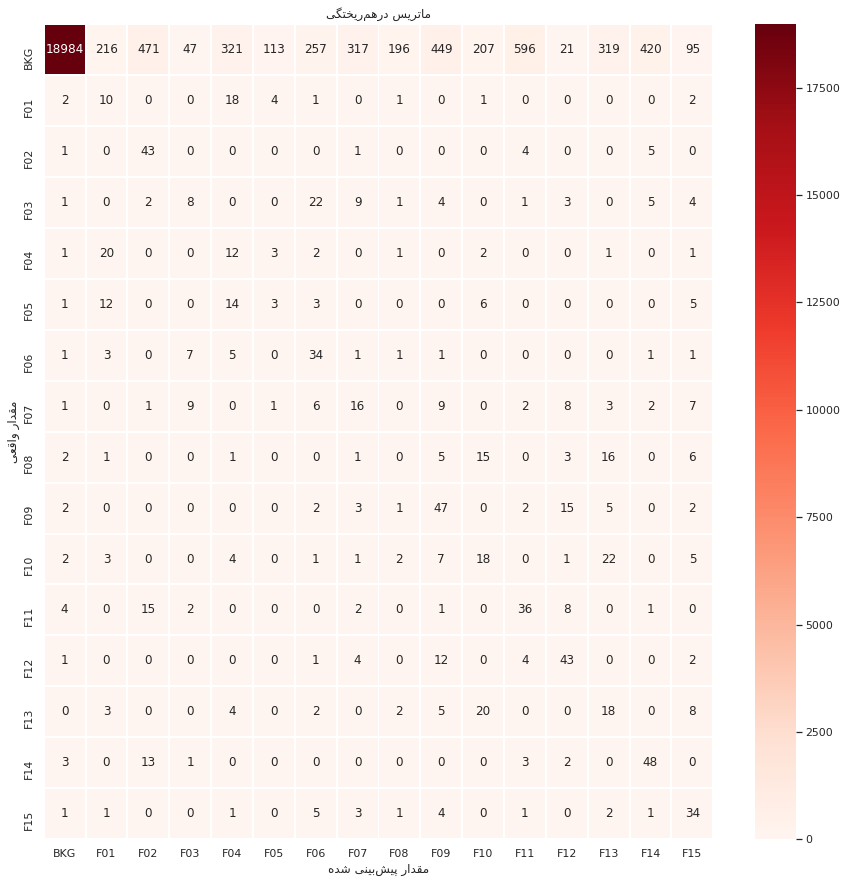

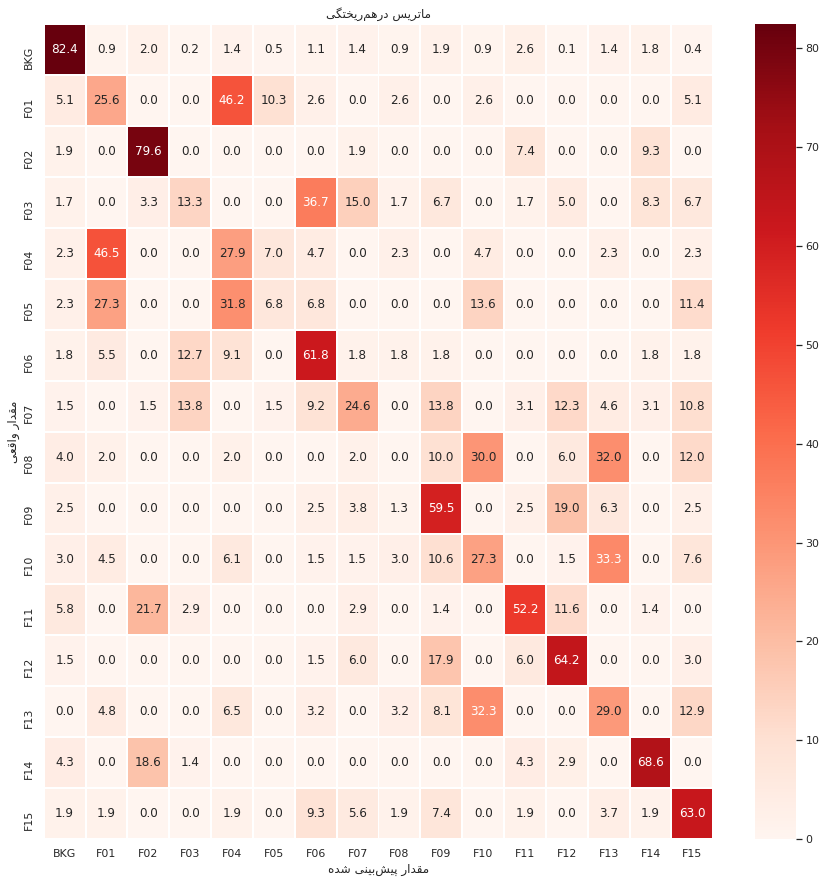

              precision    recall  f1-score   support

           0     0.9988    0.8244    0.9032     23029
           1     0.0372    0.2564    0.0649        39
           2     0.0789    0.7963    0.1436        54
           3     0.1081    0.1333    0.1194        60
           4     0.0316    0.2791    0.0567        43
           5     0.0242    0.0682    0.0357        44
           6     0.1012    0.6182    0.1739        55
           7     0.0447    0.2462    0.0757        65
           8     0.0000    0.0000    0.0000        50
           9     0.0864    0.5949    0.1509        79
          10     0.0669    0.2727    0.1075        66
          11     0.0555    0.5217    0.1003        69
          12     0.4135    0.6418    0.5029        67
          13     0.0466    0.2903    0.0804        62
          14     0.0994    0.6857    0.1736        70
          15     0.1977    0.6296    0.3009        54

    accuracy                         0.8096     23906
   macro avg     0.1494   

In [ ]:
print("\n--- Confusion matrix for test data ---\n")
y_true = np.argmax(y_test_type, axis=1)
y_pred = np.argmax(model.predict(X_test)[1], axis=1)
matrix = confusion_matrix(y_true, y_pred,LABELS_type)
print(classification_report(y_true, y_pred,digits=4))

In [ ]:
print("\n--- Confusion matrix for test data ---\n")
y_true = np.argmax(y_test_type, axis=1)
y_pred = np.argmax(model.predict(X_test)[1], axis=1)
matrix = confusion_matrix(y_true, y_pred,LABELS_type)
print(classification_report(y_true, y_pred,digits=4))


--- Confusion matrix for test data ---



NameError: ignored


--- Confusion matrix for all data ---



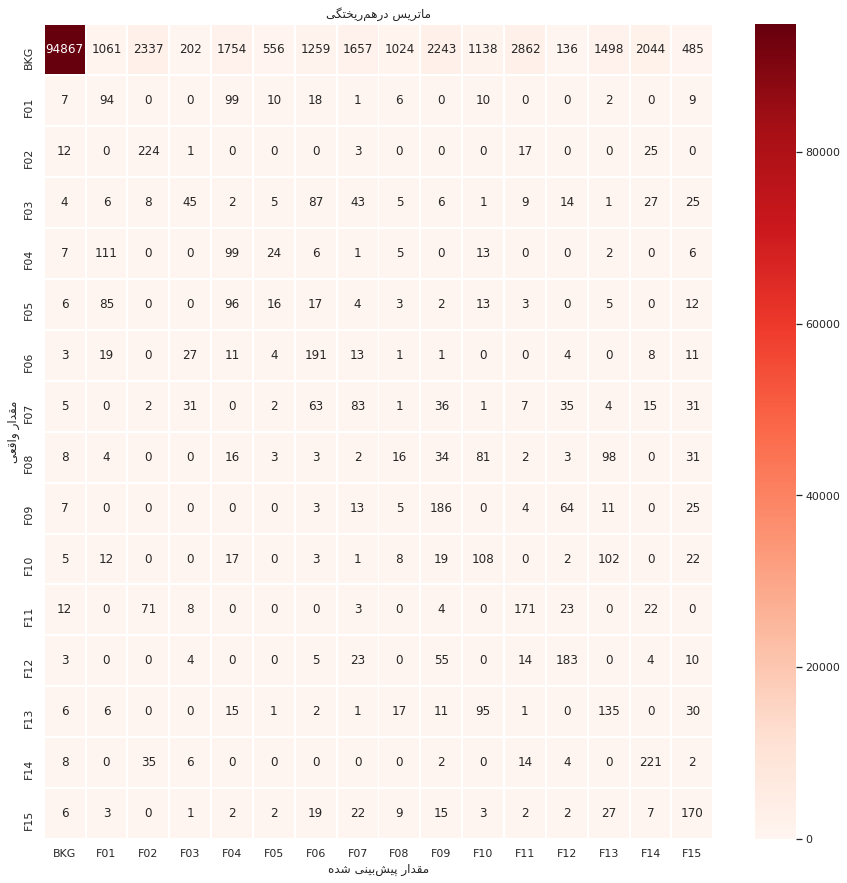

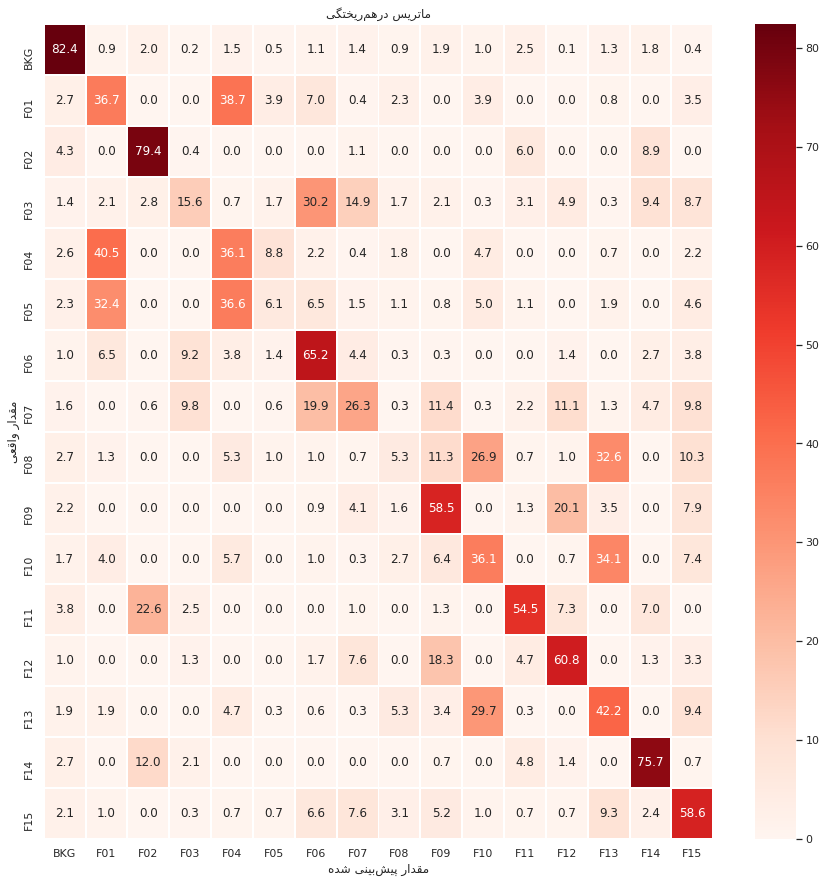

              precision    recall  f1-score   support

           0     0.9990    0.8240    0.9031    115123
           1     0.0671    0.3672    0.1135       256
           2     0.0837    0.7943    0.1514       282
           3     0.1385    0.1562    0.1468       288
           4     0.0469    0.3613    0.0830       274
           5     0.0257    0.0611    0.0362       262
           6     0.1140    0.6519    0.1940       293
           7     0.0444    0.2627    0.0759       316
           8     0.0145    0.0532    0.0228       301
           9     0.0712    0.5849    0.1269       318
          10     0.0738    0.3612    0.1226       299
          11     0.0551    0.5446    0.1000       314
          12     0.3894    0.6080    0.4747       301
          13     0.0716    0.4219    0.1224       320
          14     0.0931    0.7568    0.1659       292
          15     0.1956    0.5862    0.2934       290

    accuracy                         0.8099    119529
   macro avg     0.1552   

In [ ]:
print("\n--- Confusion matrix for all data ---\n")
y_true = np.argmax(np.concatenate([y_train_type,y_val_type,y_test_type]), axis=1)
y_pred = np.argmax(model.predict(np.concatenate([X_train,X_val,X_test]))[1], axis=1)
matrix = confusion_matrix(y_true, y_pred,LABELS_type)
print(classification_report(y_true, y_pred,digits=4))